# AI Predictions (PD Features Only)

The dataset used within this notebook utilises features that where used for Poisson distribution predictions only. This means that any other in-game football statistics were not included. Note that this script utilises the best performing set of model parameters that were obtained through the GridSearchCV from the other Jupyter Notebook.

## Prerequisites

This section consists of necessary imports and seed setting. Seeds are set to ensure having the same dataset splits whenever the script is executed.

In [1]:
# Pandas and NumPy
import pandas as pd
import numpy as np

# Other
from matplotlib import pyplot

# Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

# scikit-learn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# TensorFlow
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Setting a random seed to both TensorFlow (Keras) and NumPy
# This will ensure the same predictions are conducted over the same set (only changes if model paramaters change)

# https://stackoverflow.com/a/46119607/6361493
np.random.seed(42)
tf.random.set_seed(42)

## Retrieving & Cleaning The Data

This section retrieves the developed dataset (can be either queried directly from the database or by using the provided CSV).

In the `full_time_result` field:
<ul>
    <li>1 = Home Win</li>
    <li>0 = Draw</li>
    <li>2 = Away Win</li>
</ul>

In [3]:
betstats_data = pd.read_csv('football_dataset_pd_features_only.csv')

display(betstats_data)

,league_season,league_id,fixture_id,max_lr_fixture_date,teams_home_id,league_avg_join,fp_home,teams_away_id,fp_away,home_attack_ft,...,home_defence_1h,avg_goals_for_average_home_1h,avg_goals_for_average_away_1h,home_attack_2h,away_defence_2h,away_attack_2h,home_defence_2h,avg_goals_for_average_home_2h,avg_goals_for_average_away_2h,full_time_result
0,2018,39,75,12/08/2018 15:00,43,1,1,34,1,1.000,...,1.000,0.350,0.350,1.000,1.000,1.000,1.000,0.300,0.250,0
1,2018,39,76,12/08/2018 15:00,44,1,1,38,1,1.000,...,1.000,0.350,0.350,1.000,1.000,1.000,1.000,0.300,0.250,2
2,2018,39,77,12/08/2018 15:00,45,1,1,41,1,1.000,...,1.000,0.350,0.350,1.000,1.000,1.000,1.000,0.300,0.250,1
3,2018,39,78,12/08/2018 15:00,46,1,1,39,1,1.000,...,1.000,0.350,0.350,1.000,1.000,1.000,1.000,0.300,0.250,1
4,2018,39,79,12/08/2018 15:00,47,1,1,36,1,1.000,...,1.000,0.350,0.350,1.000,1.000,1.000,1.000,0.300,0.250,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31470,2021,39,710808,19/02/2022 15:00,51,24,24,44,22,0.570,...,0.960,0.733,0.566,0.423,0.883,0.586,0.617,0.861,0.743,2
31471,2021,39,710812,19/02/2022 15:00,50,25,25,47,23,1.708,...,0.171,0.726,0.627,1.608,0.982,0.766,0.668,0.933,0.820,2
31472,2021,42,717741,19/02/2022 15:00,1340,31,31,1339,29,0.568,...,0.695,0.528,0.484,0.524,1.117,1.664,1.888,0.764,0.559,2
31473,2021,42,717742,19/02/2022 15:00,1368,32,32,1334,30,0.938,...,1.076,0.663,0.386,0.763,0.687,1.552,1.101,0.738,0.499,2


In [4]:
# Dropping malformed records
# NULL values skew ML training

betstats_data = betstats_data.dropna()

display(betstats_data)

,league_season,league_id,fixture_id,max_lr_fixture_date,teams_home_id,league_avg_join,fp_home,teams_away_id,fp_away,home_attack_ft,...,home_defence_1h,avg_goals_for_average_home_1h,avg_goals_for_average_away_1h,home_attack_2h,away_defence_2h,away_attack_2h,home_defence_2h,avg_goals_for_average_home_2h,avg_goals_for_average_away_2h,full_time_result
0,2018,39,75,12/08/2018 15:00,43,1,1,34,1,1.000,...,1.000,0.350,0.350,1.000,1.000,1.000,1.000,0.300,0.250,0
1,2018,39,76,12/08/2018 15:00,44,1,1,38,1,1.000,...,1.000,0.350,0.350,1.000,1.000,1.000,1.000,0.300,0.250,2
2,2018,39,77,12/08/2018 15:00,45,1,1,41,1,1.000,...,1.000,0.350,0.350,1.000,1.000,1.000,1.000,0.300,0.250,1
3,2018,39,78,12/08/2018 15:00,46,1,1,39,1,1.000,...,1.000,0.350,0.350,1.000,1.000,1.000,1.000,0.300,0.250,1
4,2018,39,79,12/08/2018 15:00,47,1,1,36,1,1.000,...,1.000,0.350,0.350,1.000,1.000,1.000,1.000,0.300,0.250,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31470,2021,39,710808,19/02/2022 15:00,51,24,24,44,22,0.570,...,0.960,0.733,0.566,0.423,0.883,0.586,0.617,0.861,0.743,2
31471,2021,39,710812,19/02/2022 15:00,50,25,25,47,23,1.708,...,0.171,0.726,0.627,1.608,0.982,0.766,0.668,0.933,0.820,2
31472,2021,42,717741,19/02/2022 15:00,1340,31,31,1339,29,0.568,...,0.695,0.528,0.484,0.524,1.117,1.664,1.888,0.764,0.559,2
31473,2021,42,717742,19/02/2022 15:00,1368,32,32,1334,30,0.938,...,1.076,0.663,0.386,0.763,0.687,1.552,1.101,0.738,0.499,2


In [5]:
# Getting column information
col_list = []

for col in betstats_data.columns:
    col_list.append(col)

col_list.remove('max_lr_fixture_date')
    
col_len = len(col_list)
col_adj = col_len - 1
    
# print(col_len)
# print(col_list)


# Allocating X and Y
x = betstats_data[[col for col in col_list[0:col_adj]]].astype(float)
y = betstats_data[[col for col in col_list[col_adj:]]]

# Categorising labels (0/1/2)
y = np_utils.to_categorical(y)

# Train Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(25171, 26)
(25171, 3)
(6293, 26)
(6293, 3)


## Feature Correlation

Conducting some analysis on the list of features within the dataset.

<AxesSubplot:>

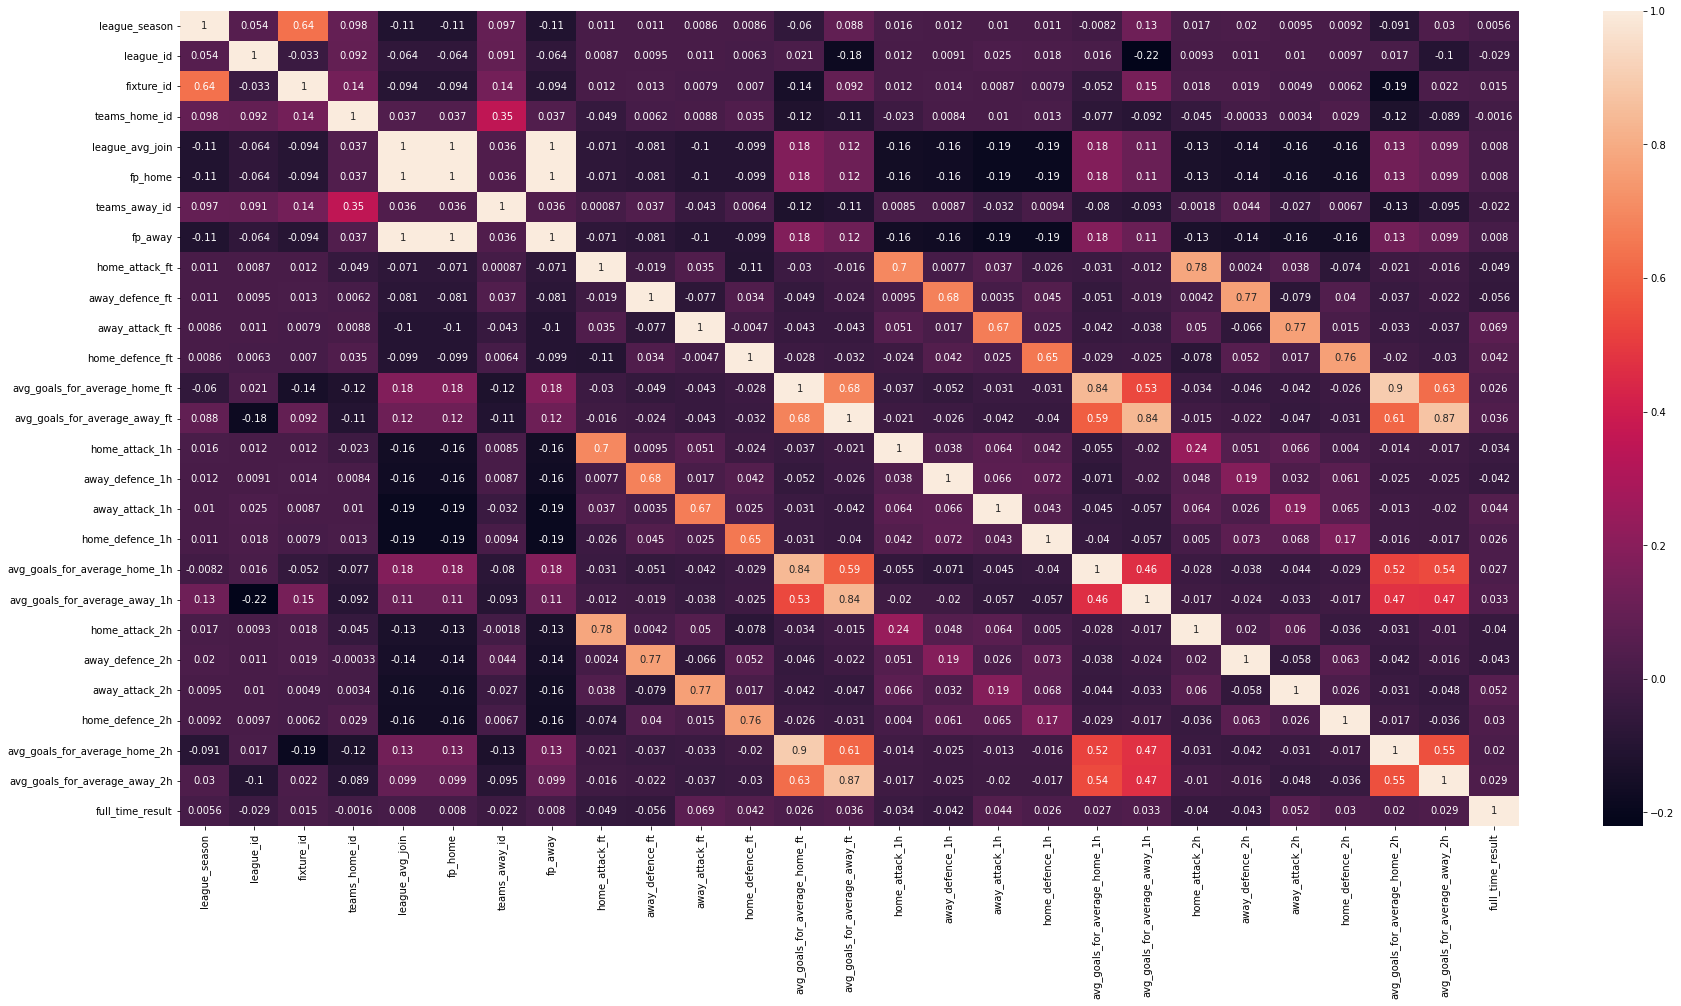

In [6]:
cor = betstats_data.corr()

plt.figure(figsize=(30, 15))
sns.heatmap(cor, annot=True)

## Normal Sequential Model

In [7]:
# I know that the intro says that we are using the same exact parameters here
# However note that the first node cannot have 75 due to the different number of fields
# That value was altered to 25

model = Sequential()
model.add(Dense(25, input_dim=col_adj, activation='relu'))
model.add(Dropout(0.0001))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_train, batch_size=32, validation_split=0.1, verbose=2, epochs=125, shuffle=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                675       
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 78        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________
Epoch 1/125
708/708 - 1s - loss: 533.8086 - accuracy: 0.3582 - val_loss: 246.0151 - val_accuracy: 0.3161
Epoch 2/125
708/708 - 0s - loss: 204.4201 - accuracy: 0.3588 - val_loss: 132.5379 - val_accuracy: 0.2998
Epoch 3/125
708/708 - 0s - loss: 188.9227 - accuracy: 0.3536 - val_loss: 166.5829 - val_accuracy: 0.2863
Epoch 4/125
708/708 - 0s - loss: 198.8094 - accuracy: 0.3557 - val_loss: 

Epoch 72/125
708/708 - 0s - loss: 109.9699 - accuracy: 0.3610 - val_loss: 155.8815 - val_accuracy: 0.3435
Epoch 73/125
708/708 - 0s - loss: 94.4545 - accuracy: 0.3640 - val_loss: 139.1189 - val_accuracy: 0.4373
Epoch 74/125
708/708 - 0s - loss: 105.1680 - accuracy: 0.3571 - val_loss: 142.7828 - val_accuracy: 0.4321
Epoch 75/125
708/708 - 0s - loss: 135.4421 - accuracy: 0.3570 - val_loss: 79.6451 - val_accuracy: 0.4142
Epoch 76/125
708/708 - 0s - loss: 105.7021 - accuracy: 0.3577 - val_loss: 117.7287 - val_accuracy: 0.4309
Epoch 77/125
708/708 - 0s - loss: 104.7691 - accuracy: 0.3569 - val_loss: 31.1100 - val_accuracy: 0.3086
Epoch 78/125
708/708 - 0s - loss: 113.0887 - accuracy: 0.3569 - val_loss: 186.1409 - val_accuracy: 0.3213
Epoch 79/125
708/708 - 0s - loss: 95.6434 - accuracy: 0.3661 - val_loss: 39.9004 - val_accuracy: 0.3531
Epoch 80/125
708/708 - 0s - loss: 105.4137 - accuracy: 0.3615 - val_loss: 137.7343 - val_accuracy: 0.4396
Epoch 81/125
708/708 - 0s - loss: 106.9898 - accura

In [8]:
# Predicting Using Sequential Model
pred_test = model.predict(x_test)
print(pred_test)

y_pred_classes = np.argmax(pred_test, axis=1)
print(y_pred_classes)

score = model.evaluate(x_test, y_test)
print('Accuracy Score:', score)

[[0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [3.4159562e-03 4.7162294e-02 9.4942170e-01]
 ...
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [1.3959759e-04 1.1729058e-02 9.8813140e-01]
 [6.2739517e-04 2.3912562e-03 9.9698132e-01]]
[2 2 2 ... 2 2 2]
197/197 [==============================] - 0s 327us/step - loss: 137.7987 - accuracy: 0.3073
Accuracy Score: [137.79867553710938, 0.3073256015777588]


In [9]:
unique, counts = np.unique(y_pred_classes, return_counts=True)
dict(zip(unique, counts))

{0: 12, 1: 458, 2: 5823}

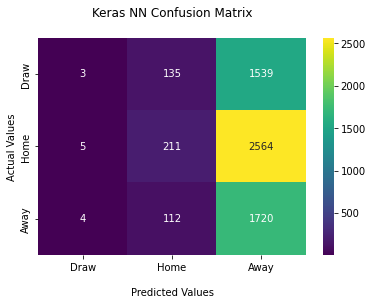

In [10]:
#Generate the confusion matrix
y_test_arg = np.argmax(y_test, axis=1)

cf_matrix = confusion_matrix(y_test_arg, y_pred_classes)

ax = sns.heatmap(cf_matrix, annot=True, cmap='viridis', fmt='d')

ax.set_title('Keras NN Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Draw', 'Home', 'Away'])
ax.yaxis.set_ticklabels(['Draw', 'Home', 'Away'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [11]:
print(classification_report(y_test_arg, y_pred_classes))

              precision    recall  f1-score   support

           0       0.25      0.00      0.00      1677
           1       0.46      0.08      0.13      2780
           2       0.30      0.94      0.45      1836

    accuracy                           0.31      6293
   macro avg       0.34      0.34      0.19      6293
weighted avg       0.36      0.31      0.19      6293



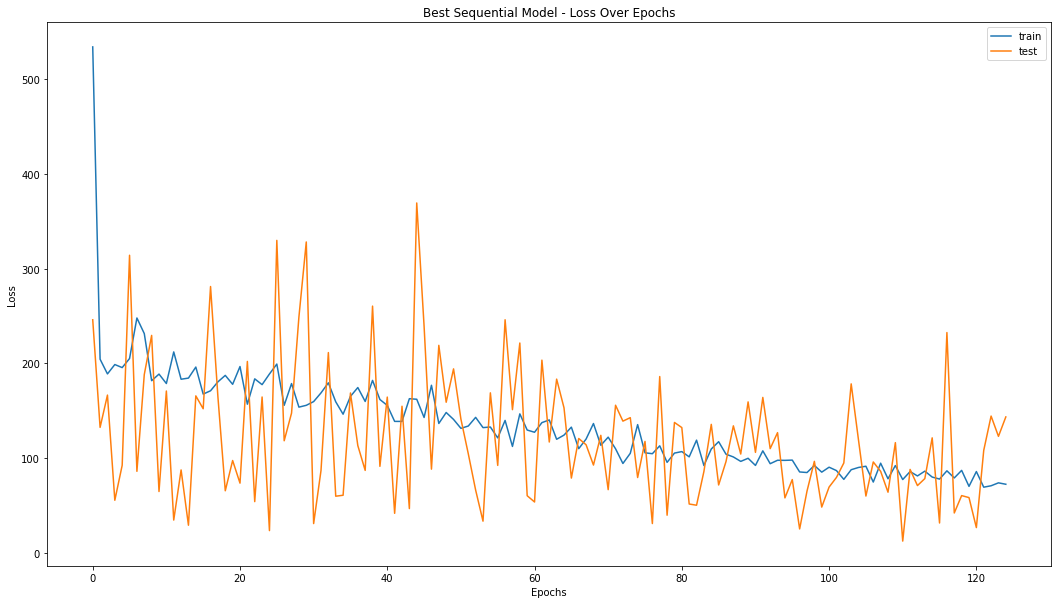

In [12]:
pyplot.figure(figsize=(18,10), dpi=72)
pyplot.title('Best Sequential Model - Loss Over Epochs')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.legend()

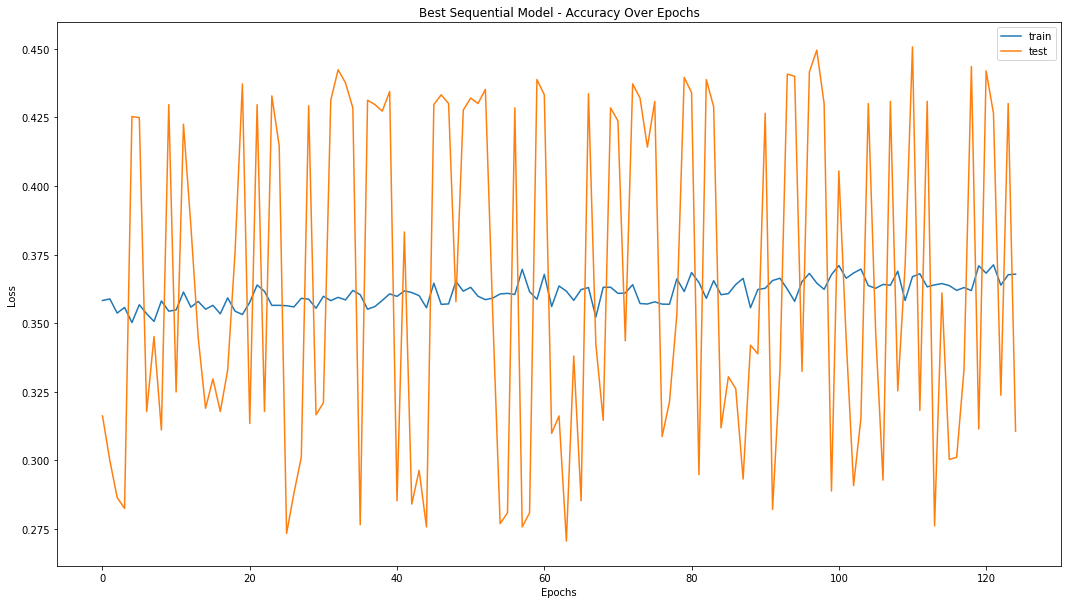

In [13]:
pyplot.figure(figsize=(18,10), dpi=72)
pyplot.title('Best Sequential Model - Accuracy Over Epochs')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.legend()

## Normal RandomForest Model

In [14]:
# I know that the intro says that we are using the same exact parameters here
# However note that the 'max_features' cannot have 50 due to the different number of fields
# That value was altered to 25

model = RandomForestClassifier(bootstrap = True,
                               max_depth = 80,
                               max_features = 25,
                               min_samples_leaf = 3,
                               min_samples_split = 8,
                               n_estimators = 100,
                               random_state = 42)

model.fit(x_train, y_train)

RandomForestClassifier(max_depth=80, max_features=25, min_samples_leaf=3,
                       min_samples_split=8, random_state=42)

In [15]:
pred_test = model.predict(x_test)
y_pred_classes = np.argmax(pred_test, axis=1)

# Will always be close to 1 (since it knows the label)
score = model.score(x_train, y_train)
print(score)

# Actual prediction accuracy
score = model.score(x_test, y_test)
print('Accuracy Score:', score)

0.9247149497437527
Accuracy Score: 0.17733990147783252


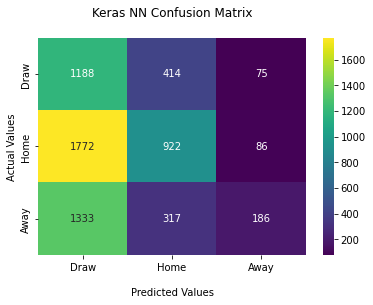

In [16]:
# Generate the confusion matrix
y_test_arg = np.argmax(y_test, axis=1)

cf_matrix = confusion_matrix(y_test_arg, y_pred_classes)

ax = sns.heatmap(cf_matrix, annot=True, cmap='viridis', fmt='d')

ax.set_title('Keras NN Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Draw', 'Home', 'Away'])
ax.yaxis.set_ticklabels(['Draw', 'Home', 'Away'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Notes

For further visualisations, kindly refer to the entire write-up or by clicking on this [link](https://docs.google.com/spreadsheets/d/1i-WSEkhrl4q6TLL68K2F5h8F2f2bGpYCKbM4Kk3aXQY/edit).